In [1]:
from ops2 import *
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.autograd import grad as torch_grad

In [2]:
class Generator(nn.Module):
    def __init__(self, z_size, channel, resnet = False, output_size = 32):
        super(Generator, self).__init__()
        s = 4
        self.output_size = output_size
        if self.output_size == 32:
            s = 4
        if self.output_size == 48:
            s = 6
        self.s = s
        self.z_size = z_size
        self.resnet = resnet
        self.fully_connect = nn.Linear(z_size, s*s*256)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.deconv1 = deconv2d(256, 256, padding = 0)
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv2 = deconv2d(256, 128, padding = 0) 
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = deconv2d(128, 64, padding = 0)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = conv2d(64, channel, padding = 1, kernel_size = 3, stride = 1)
        self.conv_res4 = conv2d(256,channel, padding = 1, kernel_size = 3, stride = 1)

        self.re1 = Residual_G(256, 256, up_sampling = True)
        self.re2 = Residual_G(256, 256, up_sampling = True)
        self.re3 = Residual_G(256, 256, up_sampling = True)
        self.bn = nn.BatchNorm2d(256)

    def forward(self, x):
        d1 = self.fully_connect(x)
        d1 = d1.view(-1, 256, self.s, self.s)
        if self.resnet == False:
            d1 = self.relu(d1)
            d2 = self.relu(self.bn1(self.deconv1(d1)))
            d3 = self.relu(self.bn2(self.deconv2(d2)))
            d4 = self.relu(self.bn3(self.deconv3(d3)))
            d5 = self.conv4(d4)
        else:
            d2 = self.re1(d1)
            d3 = self.re2(d2)
            d4 = self.re3(d3)
            d4 = self.relu(self.bn(d4))
            d5 = self.conv_res4(d4)

        return self.tanh(d5)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.z_size))


In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):

        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [4]:
model = Generator(resnet = True, z_size = 128, channel = 1)

In [5]:
unorm = UnNormalize(mean=(0.1307,), std=(0.3081,))

In [6]:
model.load_state_dict(torch.load(model_,map_location='cpu'))

<All keys matched successfully>

In [7]:
noise = torch.randn((100, 128))

In [8]:
output = model(Variable(noise))

In [9]:
smin=0
smax=255
max_i=torch.max(output)
min_i=torch.min(output)

In [10]:
output = unorm(output)

In [11]:
for i in range(32):
    for j in range(32):
        for k in range(32):
            output[i][0][j][k]=int((output[i][0][j][k]-min_i)*(smax-smin)/(max_i-min_i) + smin)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

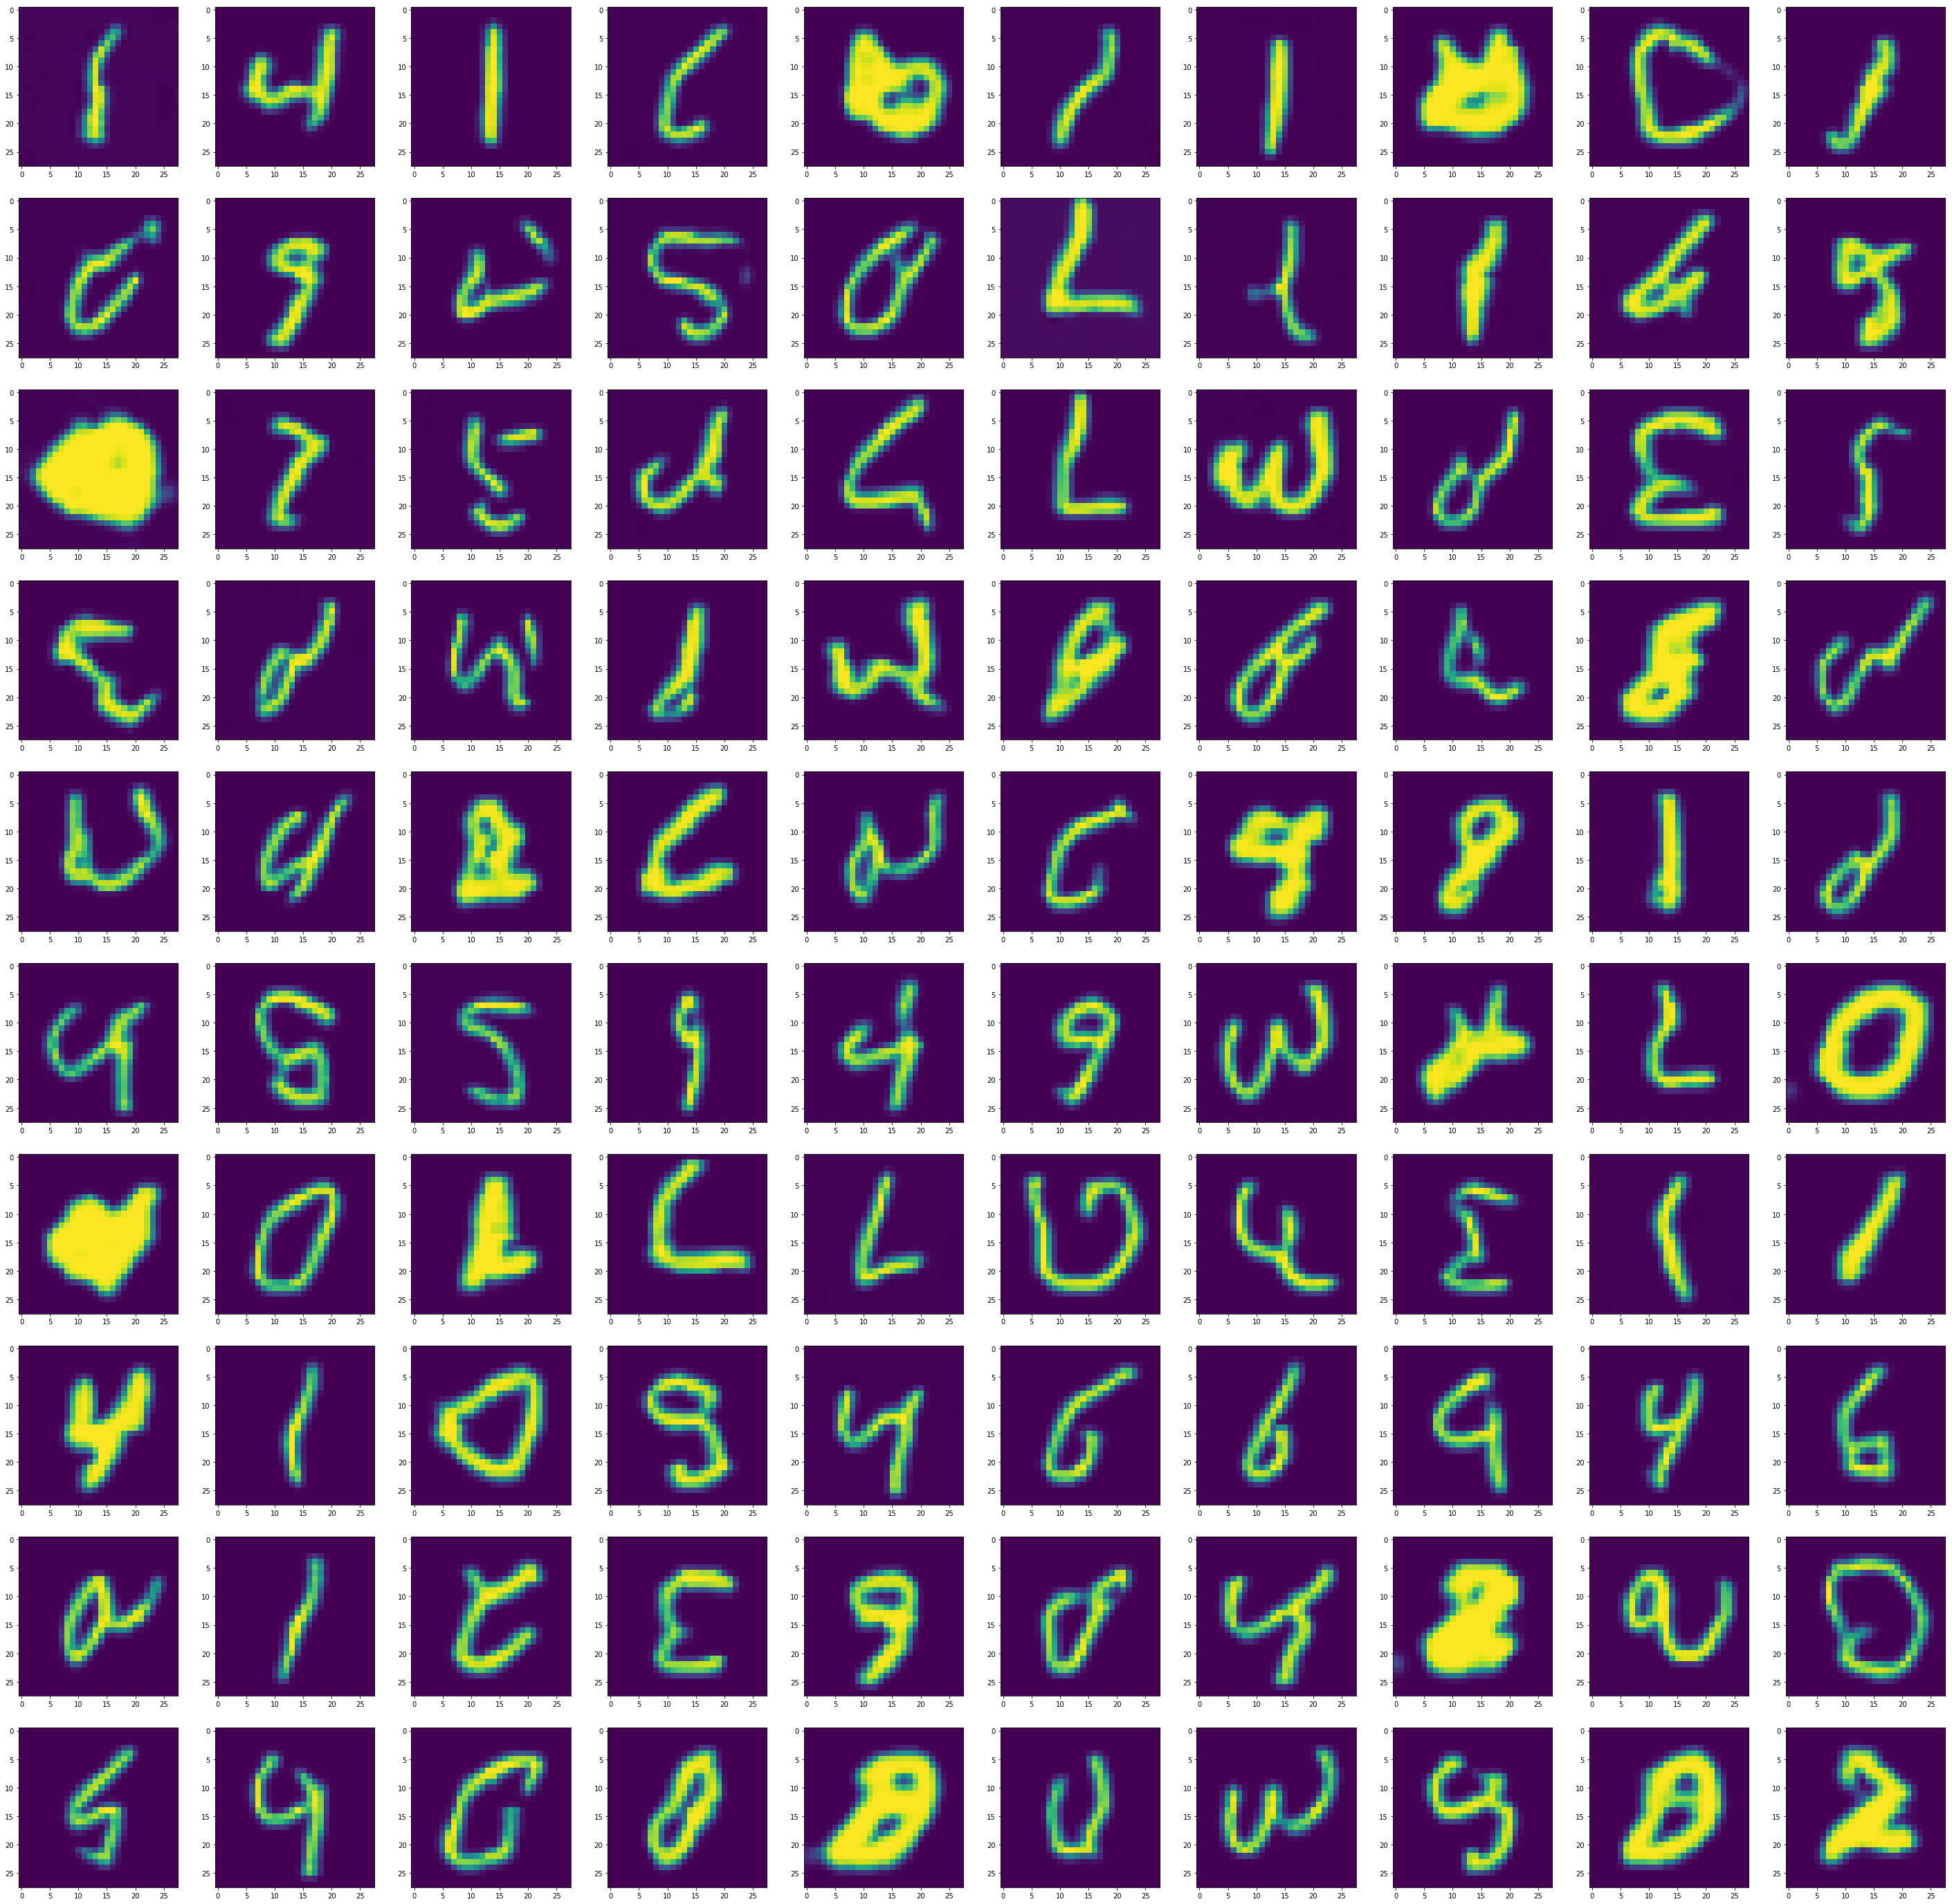

In [13]:
fig = plt.figure(figsize=(50, 50))

for i in range(100):
    sub = fig.add_subplot(10, 10, i + 1)
    res = output[i,:,:,:].detach().numpy().T
    resize = cv2.resize(res,(28,28)).T
    sub.imshow(resize, interpolation='nearest')
    plt.imsave('model_1/'+str(i)+'.png',resize)